In [ ]:
import sys
sys.path.append('../')

from cogsci2017.environment.arm_diva_env import CogSci2017Environment
from cogsci2017.learning.supervisor import Supervisor
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

iterations = 20000

environment = CogSci2017Environment(gui=False, audio=False)


config = dict(m_mins=environment.conf.m_mins,
             m_maxs=environment.conf.m_maxs,
             s_mins=environment.conf.s_mins,
             s_maxs=environment.conf.s_maxs)

agent = Supervisor(config, model_babbling="random", n_motor_babbling=1000, explo_noise=0.05)



human sounds ['eyu', 'yeo', 'eou', 'oey', 'iuo', 'uye']


In [ ]:
for i in range(iterations):
    if i % (iterations/10) == 0:
        print "Iteration", i
    context = environment.get_current_context()
    m = agent.produce(context)
    s = environment.update(m)
    agent.perceive(s)
#    s_traj = environment.diva_traj
#    if s_traj is not None:
#        if i < 100:
#            plt.plot([-f[1] for f in s_traj], [-f[0] for f in s_traj], color="r", alpha=0.2)
#        else:
#            plt.plot([-f[1] for f in s_traj], [-f[0] for f in s_traj], color="b", alpha=0.2)
#            
#plt.xlim([-11.25,-9.5])
#plt.ylim([-9.25, -7.5])

Iteration 0


../cogsci2017/environment/diva/diva.py:169: RuntimeWarning: invalid value encountered in log2
  formants = log2(transpose(res[self.s_used,:]))


error eou 0.43532031468


(-9.25, -7.5)

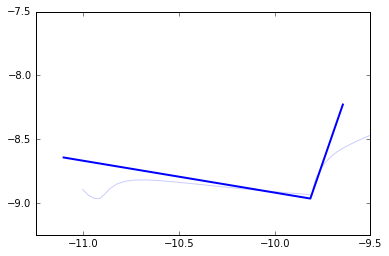

In [7]:
#for hs in human_sounds:
hs = "eou"
agent.modules["mod13"].sm.sigma_expl = np.array([0.1]*28)
#print agent.modules["mod13"].sm.sigma_expl
m = agent.modules["mod13"].inverse(np.array(environment.human_sounds_traj_std[hs]), explore=True) 
#print m
s = environment.update([0.]*21 + list(m))
s_traj = environment.diva_traj
#print s_traj
error = np.linalg.norm(np.array(environment.human_sounds_traj[hs]) - np.array([f[0] for f in s_traj[[0, 12, 24, 37, 49]]] + [f[1] for f in s_traj[[0, 12, 24, 37, 49]]]))
print "error", hs, error


plt.plot([-f[1] for f in s_traj], [-f[0] for f in s_traj], color="b", alpha=0.2)    
plt.plot(- np.array(environment.human_sounds_traj[hs][5:]), -np.array(environment.human_sounds_traj[hs][:5]), lw=2)

plt.xlim([-11.25,-9.5])
plt.ylim([-9.25, -7.5])

In [3]:

for i in range(100):
    context = environment.get_current_context()[:4]
    s_goal = [2. * np.random.random() - 1. for _ in range(10)]

    m = agent.modules["mod10"].inverse(np.array(context + s_goal), explore=True)
    m = [0.] * 21 + list(m)
    s = environment.update(m)
    if environment.produced_sound:
        print environment.produced_sound
    agent.perceive(s)

In [3]:
print agent.modules["mod10"].sm.model.imodel.fmodel.dataset.data[1]

[]


In [11]:
# TEST EVAL
n_goals = 10

eval_results = {}

for region in [1]:  
    print
    print "region", region
    eval_results[region] = {}
    for i in range(n_goals):
        eval_results[region][i] = {}
        environment.reset_toys()
        print environment.get_current_context()
        print environment.current_toy1
        for toy in ["toy1"]:
            print
            print toy
            eval_results[region][i][toy] = {}
                                    
            if toy == "toy1":
                goal = [environment.current_toy1[0] * (1. - t) / 2. for t in [0., 0.3, 0.5, 0.8, 1.]] + \
                       [environment.current_toy1[1] * (1. - t) / 2. for t in [0., 0.3, 0.5, 0.8, 1.]]
                arm_mid = "mod3"
                diva_mid = "mod10"
            elif toy == "toy2":
                goal = [environment.current_toy2[0] * (1. - t) / 2. for t in [0., 0.3, 0.5, 0.8, 1.]] + \
                       [environment.current_toy2[1] * (1. - t) / 2. for t in [0., 0.3, 0.5, 0.8, 1.]]
                arm_mid = "mod4"
                diva_mid = "mod11"
            elif toy == "toy3":
                goal = [environment.current_toy3[0] * (1. - t) / 2. for t in [0., 0.3, 0.5, 0.8, 1.]] + \
                       [environment.current_toy3[1] * (1. - t) / 2. for t in [0., 0.3, 0.5, 0.8, 1.]]
                arm_mid = "mod5"
                diva_mid = "mod12"
                
            print "goal", i, goal
            print "context", environment.get_current_context()
            context = list(agent.modules[arm_mid].get_c(environment.get_current_context()))
            dists, _ = agent.modules[arm_mid].sm.model.imodel.fmodel.dataset.nn_y(context+goal)
            arm_dist = dists[0]
            
            if len(agent.modules[diva_mid].sm.model.imodel.fmodel.dataset) > 0:
                context = list(agent.modules[diva_mid].get_c(environment.get_current_context()))
                dists, _ = agent.modules[diva_mid].sm.model.imodel.fmodel.dataset.nn_y(context+goal)
                diva_dist = dists[0]
            else:
                diva_dist = np.inf
            
            print "arm dist", arm_dist
            print "diva_dist", diva_dist
            
            if arm_dist < diva_dist:
                m = agent.modules[arm_mid].inverse(np.array(context + goal), explore=False)            
                m = list(m) + [0.]*28
            else:
                m = agent.modules[diva_mid].inverse(np.array(context + goal), explore=False)            
                m = [0.]*21 + list(m)
                
            s = environment.update(m)
            print "s", s
            
            if toy == "toy1":
                reached = s[30:40]
            elif toy == "toy2":
                reached = s[40:50]
            elif toy == "toy3":
                reached = s[50:60]
                
            comp_error = np.linalg.norm(np.array(reached) - np.array(goal))
            print "reached", reached, "error", comp_error
            
            eval_results[region][i][toy]["comp_error"] = comp_error
            eval_results[region][i][toy]["arm_dist"] = arm_dist
            eval_results[region][i][toy]["diva_dist"] = diva_dist


region 1
[-0.1958557917358974, -0.26823602474839331, 0.072529198780834886, 0.63602066499757304, -0.52915353229216067, 0.71700925698992279, -0.001233166772816557, 0.002459354331779991, 0.432695401022811, -0.28286029042706096]
[0.14505839756166977, 1.2720413299951461, 0.0]

toy1
goal 0 [0.072529198780834886, 0.050770439146584419, 0.036264599390417443, 0.014505839756166974, 0.0, 0.63602066499757304, 0.44521446549830107, 0.31801033249878652, 0.12720413299951458, 0.0]
context [-0.1958557917358974, -0.26823602474839331, 0.072529198780834886, 0.63602066499757304, -0.52915353229216067, 0.71700925698992279, -0.001233166772816557, 0.002459354331779991, 0.432695401022811, -0.28286029042706096]
arm dist 0.582050636119
diva_dist 0.846628702127
s [-0.19585579 -0.26823602 -0.09522192 -0.86094404 -0.11365238 -0.26524478
 -0.75333652 -0.041728    0.4326954  -0.28286029  0.20147982  0.15591978
  0.3975599   0.15961047  0.07279458  0.4508446  -0.01302245 -0.03152016
  0.25645571  0.18417984 -0.19585579 

In [9]:
print environment.get_current_context()
print environment.current_toy1

[-0.14030649370389509, 0.39847807190945012, -0.095221924028563887, -0.86094403748415826, -0.41798371206660895, 0.22018634937351131, -0.75333652398061124, -0.041728003704527172, 0.5990449422025557, 0.9461233108750631]
[-0.19044384805712777, -1.7218880749683165, 0.0]
